In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import costim_screen as cs

## Define Paths

In [2]:
base_path = Path('.').resolve().parent
data_path = base_path / 'data'
results_path = base_path / 'results' / 'mw_analysis'
results_path.mkdir(parents=True, exist_ok=True)

# Data paths
candidate_metadata_path = data_path / 'candidate_metadata.xlsx'
counts_path = data_path / 'merged_counts.xlsx'
sample_metadata_path = data_path / 'sample_metadata.xlsx'

# Pooled-CAR-T-Analysis paths (for pre-computed residuals)
pooled_analysis_path = base_path / 'Pooled-CAR-T-Analysis'
residuals_path = pooled_analysis_path / 'results' / 'costim_residuals.xlsx'

print(f"Data path: {data_path}")
print(f"Results path: {results_path}")
print(f"Residuals file exists: {residuals_path.exists()}")

Data path: /Users/cordessf/Library/CloudStorage/OneDrive-Personal/ACI/Repositories/CostimScreen/data
Results path: /Users/cordessf/Library/CloudStorage/OneDrive-Personal/ACI/Repositories/CostimScreen/results/mw_analysis
Residuals file exists: False


## Load Data

In [3]:
# Load count matrix and metadata
counts_wide = cs.load_counts_matrix(counts_path, candidate_id_col="CandidateID")
smeta = cs.load_sample_metadata(sample_metadata_path)
cand = cs.load_candidate_metadata(candidate_metadata_path)

# Align IDs and columns
common_candidates = counts_wide.index.intersection(cand.index)
common_samples = counts_wide.columns.intersection(smeta.index)

counts_wide = counts_wide.loc[common_candidates, common_samples]
cand = cand.loc[common_candidates]
smeta = smeta.loc[common_samples]

print(f"Counts: {counts_wide.shape[0]} CCDs × {counts_wide.shape[1]} samples")
print(f"Candidates: {len(cand)}")
print(f"Samples: {len(smeta)}")

Counts: 1071 CCDs × 144 samples
Candidates: 1071
Samples: 144


In [4]:
# Filter low-signal candidates
counts_wide = cs.filter_domains_by_total_counts(counts_wide, min_total=50)
cand = cand.loc[counts_wide.index]
print(f"After filtering: {counts_wide.shape[0]} CCDs")

# Remove GPCRs
non_gpcr_ids = cand.index[cand["is_gpcr"] == 0]
counts_wide = counts_wide.loc[non_gpcr_ids]
cand = cand.loc[non_gpcr_ids]
print(f"After removing GPCRs: {counts_wide.shape[0]} CCDs")

After filtering: 1059 CCDs
After removing GPCRs: 993 CCDs


## Load or Compute Pearson Residuals

In [5]:
if residuals_path.exists():
    print("Loading pre-computed residuals from Pooled-CAR-T-Analysis...")
    residuals_df = pd.read_excel(residuals_path).set_index("ID")
    print(f"Loaded residuals: {residuals_df.shape}")
else:
    print("Computing Pearson residuals...")
    residuals_df = cs.compute_pearson_residuals(counts_wide)
    print(f"Computed residuals: {residuals_df.shape}")

# Align with our filtered CCDs
common_ccds = residuals_df.index.intersection(counts_wide.index)
residuals_df = residuals_df.loc[common_ccds]
print(f"After alignment: {residuals_df.shape[0]} CCDs")

Computing Pearson residuals...
Computed residuals: (993, 144)
After alignment: 993 CCDs


## Build ELM Assignments

In [6]:
# Build ELM assignments from candidate metadata
print("Building ELM assignments from candidate metadata...")
elm_df = cand[["ELMCategory"]].copy()

# Custom function to parse ELM list and strip quotes
def parse_elm_list(s):
    """Parse ELM string and strip surrounding quotes from each element."""
    elms = cs.split_elm_list(s)
    # Strip quotes from each ELM name
    return [e.strip("'\"") for e in elms]

elm_df["ELMs (collapsed)"] = elm_df["ELMCategory"].apply(parse_elm_list)

# Align with our CCDs
elm_df = elm_df.loc[elm_df.index.intersection(residuals_df.index)]
print(f"ELM assignments: {len(elm_df)} CCDs")

# Get unique ELMs
all_elms = sorted(set(elm for elms in elm_df["ELMs (collapsed)"] for elm in elms))
print(f"Unique ELMs: {len(all_elms)}")
print(f"Sample ELMs: {all_elms[:5]}")

Building ELM assignments from candidate metadata...
ELM assignments: 993 CCDs
Unique ELMs: 49
Sample ELMs: ['14-3-3', 'ANK', 'APCC', 'Actin', 'Arc']


## Define Phenotypes for Analysis

In [7]:
# Map phenotype names to sample column patterns
# The residuals columns follow the pattern: {Donor}_CAR:Raji_{Tsubset}_{PD1}_{Replicate}
# e.g., "1_CAR:Raji_Naïve_High_1", "2_CAR:Raji_CM_Low_2"
PHENOTYPES = [
    "Naive_High", "Naive_Low",
    "CM_High", "CM_Low", 
    "EM_High", "EM_Low"
]

# Patterns for Raji condition (note: uses Naïve with accent in column names)
RAJI_PATTERNS = {
    "Naive_High": "_CAR:Raji_Naïve_High_",
    "Naive_Low": "_CAR:Raji_Naïve_Low_",
    "CM_High": "_CAR:Raji_CM_High_",
    "CM_Low": "_CAR:Raji_CM_Low_",
    "EM_High": "_CAR:Raji_EM_High_",
    "EM_Low": "_CAR:Raji_EM_Low_",
}

# Check which columns match each phenotype
print("Sample columns per phenotype (Raji condition):")
for pheno, pattern in RAJI_PATTERNS.items():
    cols = [c for c in residuals_df.columns if pattern in c]
    print(f"  {pheno}: {len(cols)} samples")

Sample columns per phenotype (Raji condition):
  Naive_High: 6 samples
  Naive_Low: 6 samples
  CM_High: 6 samples
  CM_Low: 6 samples
  EM_High: 6 samples
  EM_Low: 6 samples


## Run Mann-Whitney Analysis

In [8]:
# Run for all phenotypes
all_results = []

for pheno, pattern in RAJI_PATTERNS.items():
    print(f"Analyzing {pheno}...")
    results = cs.run_mw_analysis_for_phenotype(
        residuals_df, elm_df, pheno, pattern
    )
    if len(results) > 0:
        all_results.append(results)
        print(f"  {len(results)} ELMs tested")

# Combine all results
mw_results = pd.concat(all_results, ignore_index=True)
print(f"\nTotal results: {len(mw_results)} ELM-phenotype pairs")

Analyzing Naive_High...
  49 ELMs tested
Analyzing Naive_Low...
  49 ELMs tested
Analyzing CM_High...
  49 ELMs tested
Analyzing CM_Low...
  49 ELMs tested
Analyzing EM_High...
  49 ELMs tested
Analyzing EM_Low...
  49 ELMs tested

Total results: 294 ELM-phenotype pairs


In [9]:
# Apply FDR correction
mw_results["qvalue"] = cs.bh_fdr(mw_results["pvalue"])
mw_results["sig_stars"] = mw_results["qvalue"].apply(cs.get_sig_stars)

# Save results
mw_results.to_csv(results_path / "mw_all_results.csv", index=False)

# Show significant results
sig_results = mw_results[mw_results["qvalue"] < 0.10].sort_values("pvalue")
print(f"\nSignificant ELM-phenotype associations (FDR < 0.10): {len(sig_results)}")
if len(sig_results) > 0:
    print("\nTop 20 associations:")
    display(sig_results.head(20))


Significant ELM-phenotype associations (FDR < 0.10): 66

Top 20 associations:


,ELM,n_with,n_without,u_stat,pvalue,cliff_delta,n_pairs,mean_with,mean_without,median_with,median_without,phenotype,qvalue,sig_stars
242,WW,254,739,3785993.5,2.051794e-12,0.120545,6757416,-1.402980,-2.063208,-3.787903,-6.933189,EM_High,6.032275e-10,***
41,TYR,88,905,1223727.0,2.697307e-08,-0.146348,2867040,-9.489681,-1.034495,-6.919417,-5.018248,Naive_High,3.965041e-06,***
46,WW,254,739,3684061.5,1.354782e-07,0.090376,6757416,1.022752,-2.748429,-3.791820,-5.942093,Naive_High,1.327687e-05,***
231,SH3,231,762,3423819.0,5.280537e-06,0.080616,6336792,-0.899989,-2.195762,-4.768122,-6.537499,EM_High,3.881195e-04,***
291,WW,254,739,3635274.0,9.464337e-06,0.075936,6757416,-0.472551,-0.893321,-4.195605,-6.896347,EM_Low,5.309428e-04,***
240,WD40,534,459,4703152.0,1.083557e-05,0.066013,8823816,-2.428860,-1.272454,-5.308154,-7.207306,EM_High,5.309428e-04,***
34,SH2,452,541,4114982.0,1.460112e-05,-0.065112,8803152,-3.944471,0.021425,-5.612813,-4.710639,Naive_High,6.132471e-04,***
224,PP2A,56,937,1075804.5,1.808886e-05,0.139025,1888992,-0.078790,-2.002834,-3.361622,-6.163144,EM_High,6.647657e-04,***
229,REV1ctd,29,964,596012.0,3.306556e-05,0.184425,1006416,9.293440,-2.230890,-4.081681,-6.062161,EM_High,1.080142e-03,**
286,TYR,88,905,1283005.5,6.635264e-05,-0.104996,2867040,-8.832665,-0.003224,-7.180919,-5.845494,EM_Low,1.950768e-03,**


## Volcano Plots by Phenotype

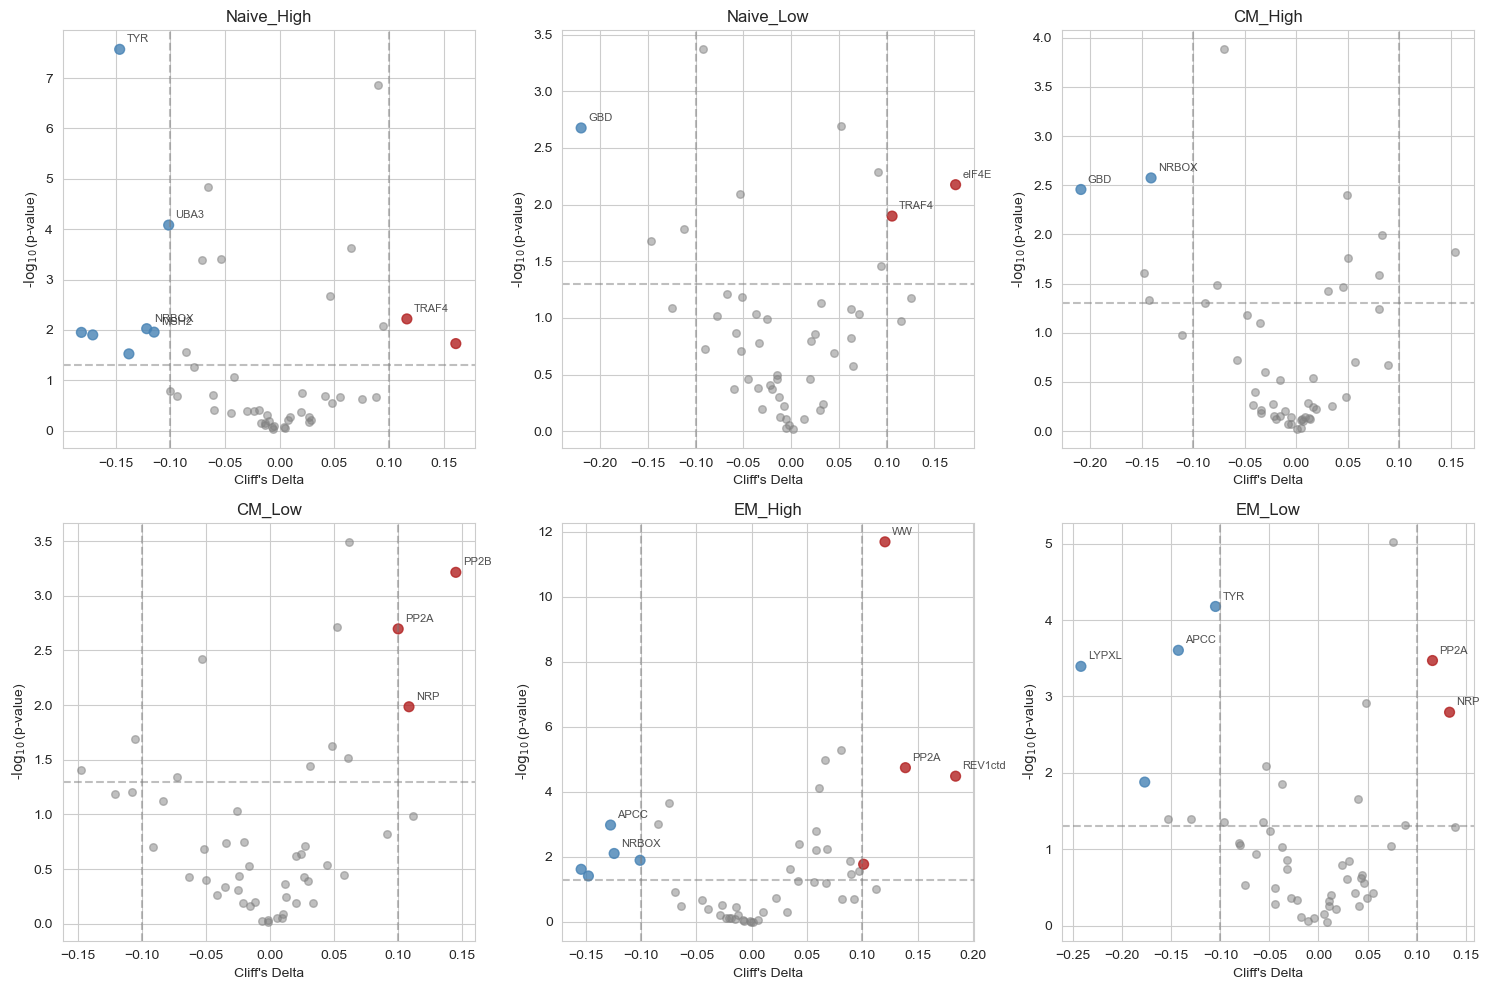

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, pheno in enumerate(PHENOTYPES):
    ax = axes[i]
    pheno_df = mw_results[mw_results["phenotype"] == pheno].copy()
    
    if len(pheno_df) == 0:
        ax.text(0.5, 0.5, f"No data for {pheno}", ha="center", va="center")
        ax.set_title(pheno)
        continue
    
    cs.mw_volcano_plot(
        pheno_df,
        q_thresh=0.10,
        delta_thresh=0.1,
        title=pheno,
        top_n_labels=5,
        ax=ax,
    )

plt.tight_layout()
plt.savefig(results_path / "volcano_all_phenotypes.png", dpi=300, bbox_inches="tight")
plt.show()

## Heatmap of Effects

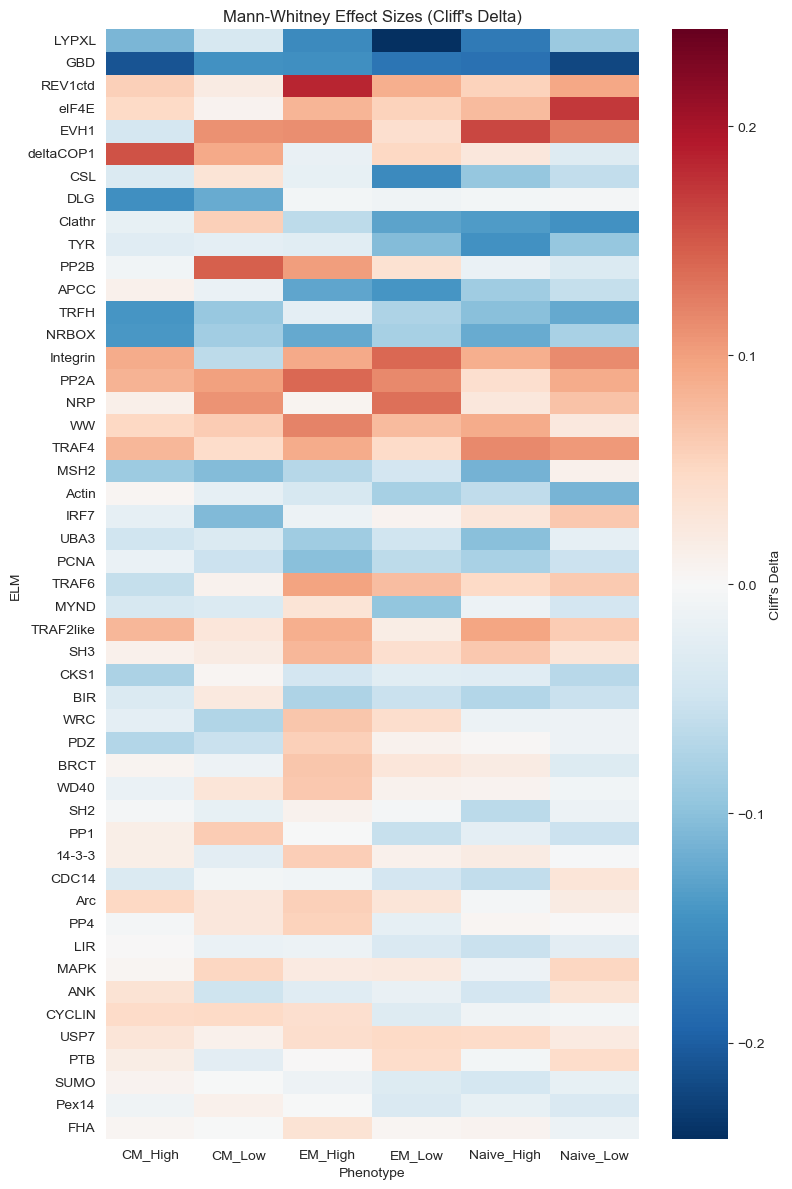

In [11]:
# Pivot to create heatmap
heatmap_data = mw_results.pivot(
    index="ELM",
    columns="phenotype",
    values="cliff_delta"
)

# Sort by max absolute effect
heatmap_data = heatmap_data.loc[
    heatmap_data.abs().max(axis=1).sort_values(ascending=False).index
]

# Plot
fig, ax = plt.subplots(figsize=(8, 12))

vmax = heatmap_data.abs().values.max()
sns.heatmap(
    heatmap_data,
    cmap="RdBu_r",
    center=0,
    vmin=-vmax,
    vmax=vmax,
    ax=ax,
    cbar_kws={"label": "Cliff's Delta"},
)

ax.set_xlabel("Phenotype")
ax.set_ylabel("ELM")
ax.set_title("Mann-Whitney Effect Sizes (Cliff's Delta)")

plt.tight_layout()
plt.savefig(results_path / "heatmap_cliff_delta.png", dpi=300, bbox_inches="tight")
plt.show()

heatmap_data.to_csv(results_path / "heatmap_cliff_delta.csv")

## Pooled Contrasts

Similar to DM analysis, we compute pooled effects across T-subsets (averaging over PD1 levels).

In [12]:
# Compute pooled T-subset effects
pooled_tsubset = []
for elm in all_elms:
    for ts in ["Naive", "CM", "EM"]:
        pooled_tsubset.append(cs.compute_pooled_tsubset_effect(mw_results, elm, ts))

pooled_tsubset_df = pd.DataFrame(pooled_tsubset)
pooled_tsubset_df["qvalue"] = cs.bh_fdr(pooled_tsubset_df["pvalue"])

print(f"Pooled T-subset results: {len(pooled_tsubset_df)}")
print(f"Significant (FDR < 0.10): {(pooled_tsubset_df['qvalue'] < 0.10).sum()}")

pooled_tsubset_df.to_csv(results_path / "pooled_tsubset_results.csv", index=False)

Pooled T-subset results: 147
Significant (FDR < 0.10): 53


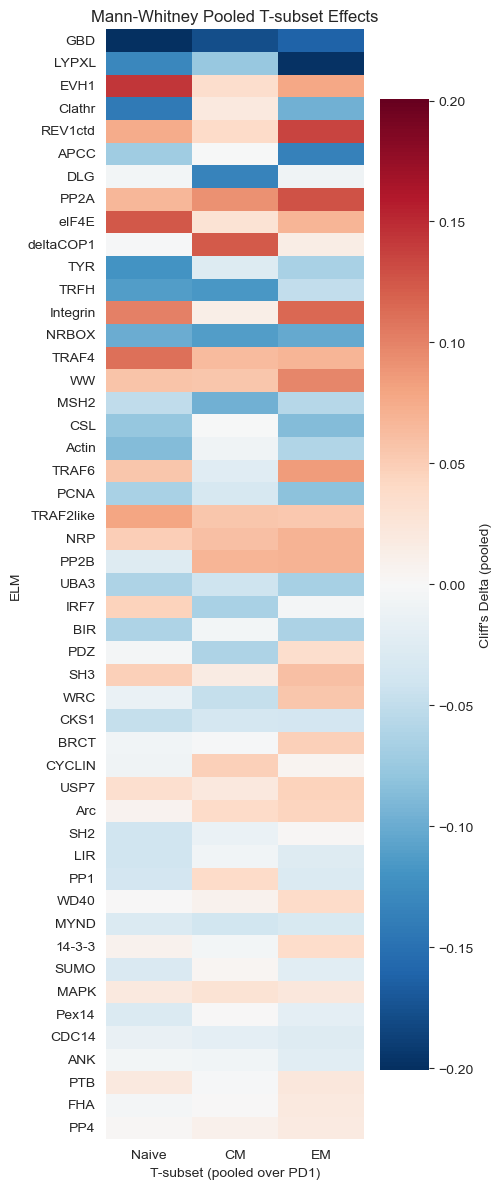

In [13]:
# Heatmap of pooled T-subset effects
pooled_heatmap = pooled_tsubset_df.pivot(
    index="ELM",
    columns="tsubset",
    values="cliff_delta"
)[["Naive", "CM", "EM"]]  # Order columns

# Sort by max absolute
pooled_heatmap = pooled_heatmap.loc[
    pooled_heatmap.abs().max(axis=1).sort_values(ascending=False).index
]

fig, ax = plt.subplots(figsize=(5, 12))

vmax = pooled_heatmap.abs().values.max()
sns.heatmap(
    pooled_heatmap,
    cmap="RdBu_r",
    center=0,
    vmin=-vmax,
    vmax=vmax,
    ax=ax,
    cbar_kws={"label": "Cliff's Delta (pooled)"},
)

ax.set_xlabel("T-subset (pooled over PD1)")
ax.set_ylabel("ELM")
ax.set_title("Mann-Whitney Pooled T-subset Effects")

plt.tight_layout()
plt.savefig(results_path / "heatmap_pooled_tsubset.png", dpi=300, bbox_inches="tight")
plt.show()

## Comparison with Dirichlet-Multinomial Results

Loading DM results for comparison...
  Mapped 49 unique ELMs
Matched ELM-phenotype pairs: 294

Spearman correlation (Cliff's delta vs log2FC): r=0.255, p=9.88e-06


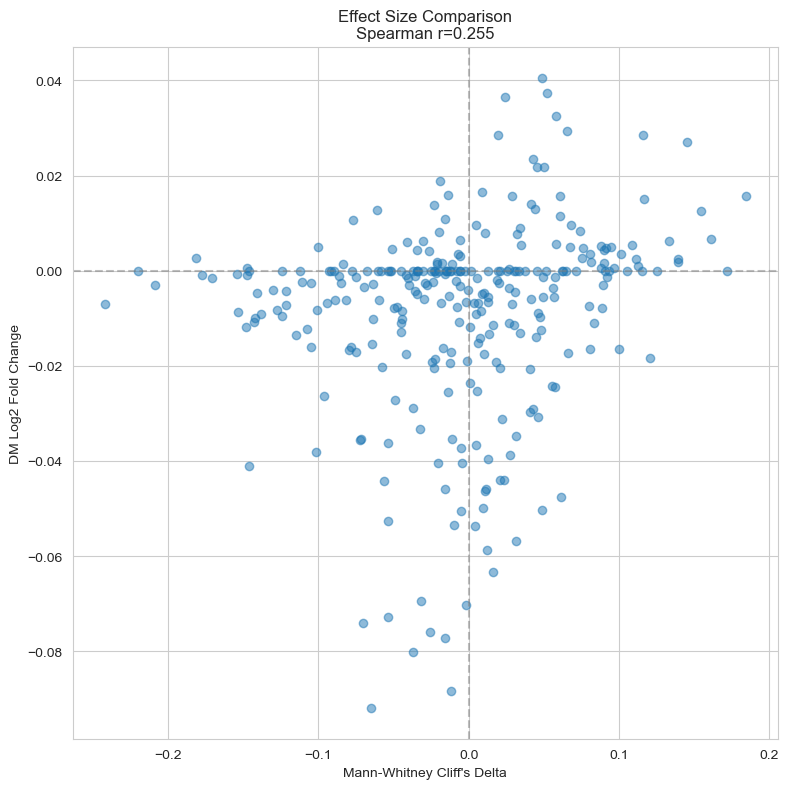

In [14]:
# Load DM results if available
dm_results_path = base_path / 'results' / 'dm_analysis' / 'dm_all_effects.csv'
elm_mapping_path = base_path / 'results' / 'dm_analysis' / 'elm_feature_name_map.csv'

if dm_results_path.exists():
    print("Loading DM results for comparison...")
    dm_df = pd.read_csv(dm_results_path)
    
    # Load ELM name mapping (DM uses patsy-safe names)
    if elm_mapping_path.exists():
        elm_mapping = pd.read_csv(elm_mapping_path, header=None, index_col=0)
        # Create reverse mapping: safe_name -> raw_name
        reverse_map = {v: k.strip("'") for k, v in elm_mapping[1].items() if pd.notna(k)}
        # Map DM ELM names back to raw names
        dm_df["ELM_raw"] = dm_df["ELM"].map(reverse_map).fillna(dm_df["ELM"])
        print(f"  Mapped {dm_df['ELM_raw'].nunique()} unique ELMs")
    else:
        dm_df["ELM_raw"] = dm_df["ELM"]
    
    # Merge MW and DM results
    comparison = mw_results.merge(
        dm_df,
        left_on=["ELM", "phenotype"],
        right_on=["ELM_raw", "Phenotype"],
        suffixes=("_mw", "_dm")
    )
    
    print(f"Matched ELM-phenotype pairs: {len(comparison)}")
    
    # Correlation between effect sizes
    valid = comparison.dropna(subset=["cliff_delta", "log2FC"])
    if len(valid) > 0:
        r, p = stats.spearmanr(valid["cliff_delta"], valid["log2FC"])
        print(f"\nSpearman correlation (Cliff's delta vs log2FC): r={r:.3f}, p={p:.2e}")
        
        # Scatter plot
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.scatter(valid["cliff_delta"], valid["log2FC"], alpha=0.5)
        ax.set_xlabel("Mann-Whitney Cliff's Delta")
        ax.set_ylabel("DM Log2 Fold Change")
        ax.set_title(f"Effect Size Comparison\nSpearman r={r:.3f}")
        ax.axhline(0, color="gray", linestyle="--", alpha=0.5)
        ax.axvline(0, color="gray", linestyle="--", alpha=0.5)
        
        plt.tight_layout()
        plt.savefig(results_path / "comparison_mw_vs_dm.png", dpi=300)
        plt.show()
        
        # Save comparison
        comparison.to_csv(results_path / "comparison_mw_vs_dm.csv", index=False)
else:
    print("DM results not found. Run 02_dirichlet_multinomial_analysis.ipynb first.")

# Summary

This notebook applied the Mann-Whitney U test to compare ELM effects on CAR-T cell phenotypes.

**Key outputs:**
- `mw_all_results.csv` - Full table of ELM-phenotype test results
- `pooled_tsubset_results.csv` - Pooled T-subset effects
- Volcano plots per phenotype
- Heatmaps of Cliff's delta effect sizes
- Comparison with Dirichlet-Multinomial results

**Interpretation:**
- Cliff's delta: Effect size measure (-1 to 1)
  - |δ| < 0.147: negligible
  - 0.147 ≤ |δ| < 0.33: small
  - 0.33 ≤ |δ| < 0.474: medium
  - |δ| ≥ 0.474: large
- Positive δ: ELM associated with higher residuals (enrichment)
- Negative δ: ELM associated with lower residuals (depletion)